### Useful links
- [CampusX - Handwritten Digit Classification using ANN](https://www.youtube.com/watch?v=3xPT2Pk0Jds)
- [Shubham Singh - The EMNIST dataset letter recognition](https://www.youtube.com/watch?v=3xPT2Pk0Jds)
- [Emnist classification](https://github.com/sejalgupta01/EMNIST-Classification/blob/master/EMNIST_Classification%20(3).ipynb)
- [Deep learning-Deep understanding by shubham singh](https://www.youtube.com/playlist?list=PL2FZtB-DAFqk4iXGu1xK1_fUmTCjtfQhV)
- [Neural Network from Scratch | Mathematics & Python Code](https://www.youtube.com/watch?v=pauPCy_s0Ok)
- https://github.com/khelli07/ai-fnn/blob/main/README.md
- https://khelli07.medium.com/introduction-to-artificial-neural-network-in-deep-learning-aa7ba2280f50
- https://khelli07.medium.com/feedforward-neural-network-fnn-implementation-from-scratch-using-python-467f51ecca3d
- https://towardsdatascience.com/creating-neural-networks-from-scratch-in-python-6f02b5dd911
- https://subscription.packtpub.com/book/data/9781789346640/1/ch01lvl1sec05/feed-forward-propagation-from-scratch-in-python
- [Softmax Layer from Scratch ](https://www.youtube.com/watch?v=AbLvJVwySEo)

### Dependencies

In [6]:
# ! pip install torchvision
# ! pip install tqdm
# ! pip install matplotlib
# ! pip install scikit-learn
# ! pip install seaborn

In [7]:
# fix random seed
import numpy as np
np.random.seed(0)
np.random.RandomState(0)

# torch random seed
import torch
torch.manual_seed(0)

import torchvision.datasets as ds
import torchvision.transforms as transforms
from tqdm import tqdm

### Dataset

In [8]:
# Download the training and validation datasets

train_val_ds = ds.EMNIST(
    root="./data",
    split="letters",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)


In [9]:

test_ds = ds.EMNIST(
    root="./data",
    split="letters",
    train=False,
    transform=transforms.ToTensor(),
)


### Preprocessing

In [10]:
# get labels
labels = np.array(train_val_ds.targets)
# get unique labels
unique_labels = np.unique(labels)

# print number of samples per class
# for label in unique_labels:
#     print(f"number of samples for class {label}: {np.sum(labels == label)}")

In [11]:
# remove 'N/A' label and decrease all labels by 1
train_val_ds.targets = train_val_ds.targets - 1
test_ds.targets = test_ds.targets - 1

train_val_ds.classes = train_val_ds.classes[1:]
test_ds.classes = test_ds.classes[1:]

#### Data Normalization

In [12]:
# next issue: do we need to normalize the data?
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
# normalize the data
train_val_ds.data = train_val_ds.data / torch.max(train_val_ds.data)
test_ds.data = test_ds.data / torch.max(test_ds.data)

### Train-validation split
The dataset contains 28x28 images of letters from the Latin alphabet. Split the train-validation dataset as 85%-15% to form your train set and validation set. 

In [14]:
# convert torch to numpy
train_val_ds.data = train_val_ds.data.numpy()
train_val_ds.targets = train_val_ds.targets.numpy()

# convert torch to numpy
test_ds.data = test_ds.data.numpy()
test_ds.targets = test_ds.targets.numpy()

In [15]:
# use sklearn to split train_validation_dataset into train and validation datasets
from sklearn.model_selection import train_test_split

val_per = 0.15 # validation percentage

# split train_validation_dataset into train and validation datasets as 85% and 15% respectively
train_ds, val_ds, train_labels, val_labels = train_test_split(
    train_val_ds.data,
    train_val_ds.targets,
    test_size=val_per,
    random_state=1,
)

### FFN implementation

##### Loss function
As you can see, our example model is currently random. To remedy this, we need a way to
calculate how wrong the neural network is at current predictions and begin adjusting weights
and biases to decrease error over time. Thus, our next step is to quantify how wrong the model is
through what’s defined as a loss function.

In [16]:
# no matter which loss function we’ll use, the overall loss is always a mean value of all sample losses
# common loss functions
class Loss:
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss
        return data_loss

##### Activation function

In [17]:
class Activation:
    def forward(self, inputs):
        raise NotImplementedError
    def backward(self, grad_outputs):
        raise NotImplementedError
    

In [18]:
# ReLU activation
class ReLU(Activation):
    def forward(self, inputs):
        self.inputs = inputs
        return np.maximum(0, inputs)
    
    def backward(self, grad_outputs):
        # Since we need to modify original variable,
        # let’s make a copy of values first
        grad_inputs = grad_outputs.copy()

       # print(f"Relu grad_output shape: {grad_outputs.shape}")

        # Zero gradient where input values were negative
        grad_inputs[self.inputs <= 0] = 0

       # print(f"Relu grad_input shape: {grad_inputs.shape}")

        return grad_inputs

In [19]:
class Softmax(Activation):

    def forward(self, inputs):
        # get row max to subtract from each row
        # this is to prevent overflow
        # the max value in each row will be 0
        # the output will be extactly the same
        row_maxs = np.max(inputs, axis=1, keepdims=True)

        # Get unnormalized probabilities
        # exponentiate values
        exp_values = np.exp(inputs - row_maxs)

        # Get normalization bases for each sample
        norm_bases = np.sum(exp_values, axis=1, keepdims=True)

        # Normalize them for each sample
        probabilities = exp_values / norm_bases

        #print(f"softmax forward output shape: {probabilities.shape}")

        self.outputs = probabilities

        return probabilities
    

    # back propagation
    def backward(self, grad_output):
        # return input_grads
       # print(f"softmax-> grad_output shape: {grad_output.shape}")
        grad_input = self.outputs * (grad_output - np.sum(self.outputs * grad_output, axis=-1, keepdims=True))
       # print(f"softmax-> grad_input shape: {grad_input.shape}")
        return grad_input

In [20]:
class Optimizer:
    # Update parameters
    def update_weights(self, weights, grad_weights):
        raise NotImplementedError
    # update bias
    def update_bias(self, bias, grad_bias):
        raise NotImplementedError

##### layer

In [21]:
class Layer:
    def forward(self, inputs):
        raise NotImplementedError
    
    def backward(self, grad_outputs, optimizer=None):
        raise NotImplementedError
    
    def summary(self):
        raise NotImplementedError

In [22]:
class Flatten(Layer):
    def __init__(self):
        self.input_shape = None
    
    def forward(self, inputs):
        # chec if 2D for batch size
        if len(inputs.shape) <= 1:
            raise ValueError(f"Flatten layer input shape must be greater than 1D. Got {inputs.shape}.")

        # save shape for backward pass
        self.input_shape = inputs.shape

        # flatten inputs
        return inputs.reshape(inputs.shape[0], -1)
    
    def backward(self, grad_outputs, optimizer=None):
        # reshape gradient
        return grad_outputs.reshape(self.input_shape)
    
    def summary(self):
        return "Flatten"

In [23]:
# Dense or fully connected layer
class DenseLayer(Layer):
    # Here, we’re setting weights to be random and biases to be 0
    def __init__(self, 
                 n_inputs:int, 
                 n_neurons:int, 
                 activation:Activation,
                 learning_rate:float = 0.001,
                 debug:bool = False,
                 ) -> None:
        # Xavier initialization
        # We divide by n_inputs to reduce the variance of our outputs
        # and make sure that they are all in the same range
        self.weights = np.random.randn(n_inputs, n_neurons) / np.sqrt(n_inputs)

        # print max and min weights
        if debug:
            print(f"weights shape: {self.weights.shape}")
            print(f"weight (min, max) = ({np.min(self.weights)}, {np.max(self.weights)})")
           
        # xaiver initialization
        self.biases = np.zeros((1, n_neurons))

        if debug:
            print(f"baises shape: {self.biases.shape}")
            print(f"bias (min, max) = ({np.min(self.biases)}, {np.max(self.biases)})")
            

        # activation function
        self.activation = activation
        # learning rate
        self.learning_rate = learning_rate

    # Forward pass
    # When we pass data through a model from beginning to end, this is called a forward pass. 
    def forward(self, inputs:np.ndarray):
        # check input shape
        if len(inputs.shape) != 2:
            raise ValueError(f"input shape must be 2D, got {len(inputs.shape)}D")
        
        # save input
        self.inputs = inputs

        # inputs shape: (batch_size, n_inputs)
        # weights shape: (n_inputs, n_neurons)
        # biases shape: (1, n_neurons)
        # output shape: (batch_size, n_neurons) i.e for each sample, we get n_neurons outputs
        out =  np.dot(inputs, self.weights) + self.biases
     
        out = self.activation.forward(out)
        return out
    
    def backward(self, grad_output:np.ndarray, optimizer:Optimizer):
        # activation function derivative
        grad_output = self.activation.backward(grad_output)

      #  print(f"denselayer-> grad_output shape: {grad_output.shape}")

        # Gradients on parameters
        # dE/dW = dE/dY * dY/dW = dE/dY * X.T
        grad_weights = np.dot(self.inputs.T, grad_output)

        # dE/dB = dE/dY * dY/dB = dE/dY * 1
        grad_biases = grad_output.mean(axis=0) * self.inputs.shape[0]

        # Gradient on values
        # dE/dX = dE/dY * dY/dX = W.T * dE/dY
        grad_inputs = np.dot(grad_output, self.weights.T)

    
        self.weights = optimizer.update_weights(self.weights, grad_weights)
        self.biases = optimizer.update_bias(self.biases,grad_biases)

        return grad_inputs
    
    def summary(self):
        activation_name = self.activation.__class__.__name__
        return f"Dense({self.weights.shape[0]}, {self.weights.shape[1]}), activation: {activation_name}"
    

#### Dropout layer

In [24]:
# Dropout
class DropoutLayer:
    # Init
    def __init__(self, dropout_rate=0.3):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - dropout_rate

    # Forward pass
    def forward(self, inputs):
        # Generate and save scaled mask
        self.mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate

        # Apply mask to output values
        return inputs * self.mask

    # Backward pass
    def backward(self, grad_output, _):
        # Gradient on values
        return grad_output * self.mask
    
    def summary(self):
        return f"Dropout(rate: {1-self.rate})"

#### Categorical cross entropy derivative

In [25]:
class CategoricalCrossEntropyLoss(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values-only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        
        return negative_log_likelihoods
    
    def backward(self, y_pred, y_true):
        # Number of samples
        samples = len(y_pred)

        # Number of labels in every sample
        # We’ll use the first sample to count them
        labels = len(y_pred[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        epsilon = 1e-7

        # Calculate gradient
        grad_output = -y_true / (y_pred+epsilon)
        # Normalize gradient
        grad_output = grad_output / samples

        return grad_output

#### Optimizer

In [26]:
# SGD
class SGD(Optimizer):
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate:float = 1.0) -> None:
        self.learning_rate = learning_rate

    # Update parameters
    def update_weights(self, weights, grad_weights):
        return weights - grad_weights * self.learning_rate
    
    # update bias
    def update_bias(self, bias, grad_bias):
        return bias - grad_bias * self.learning_rate

#### Model

In [27]:
class History:
    def __init__(self) -> None:
        self.loss = []
        self.accuracy = []
        self.val_loss = []
        self.val_accuracy = []
        self.val_f1 = []
    
    def append(self, loss, accuracy, val_loss, val_accuracy, val_f1):
        self.loss.append(loss)
        self.accuracy.append(accuracy)
        self.val_loss.append(val_loss)
        self.val_accuracy.append(val_accuracy)
        self.val_f1.append(val_f1)

In [28]:
class BestModel:
    def __init__(self) -> None:
        self.layers = None
        self.loss = np.inf
        self.accuracy = 0
        self.f1 = 0 

    def update(self, layers, loss, accuracy, f1):
        if f1 > self.f1:
            self.layers = layers.copy()
            self.loss = loss
            self.accuracy = accuracy
            self.f1 = f1

    def _forward(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

In [29]:
# import pickle
import pickle
# import sklern for f1 score
from sklearn.metrics import f1_score
# import confusion matrix
from sklearn.metrics import confusion_matrix
# import accuracy score
from sklearn.metrics import accuracy_score

# import seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

class FNN:
    def __init__(self, 
                 loss:Loss, 
                 optimizer:Optimizer, 
                 learning_rate:float = 0.005,
                 layers:list = [],
                 debug:bool = False,
                 ) -> None:
        self.loss = loss
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.debug = debug

        # history
        self.history = History()
        # best model
        self.best_model = BestModel()
        # layers
        self.layers = layers

    def add(self, layer:Layer):
        self.layers.append(layer)

    # add multiple layers
    def add_all(self, layers:list):
        self.layers.extend(layers)

    # summary
    def summary(self):
        print(f"Model summary")
        print(f"==============")
        optimizer = self.optimizer.__class__.__name__
        print(f"Optimizer: {optimizer}")
        loss = self.loss.__class__.__name__
        print(f"Loss: {loss}")
        learning_rate = self.learning_rate
        print(f"Learning rate: {learning_rate}")
        for i, layer in enumerate(self.layers):
            print(f"Layer {i+1}: {layer.summary()}")
        print(f"Output shape: {self.layers[-1].weights.shape[1]}")

    def save(self, path):
        # clear unnecessary data
        for layer in self.layers:
            if hasattr(layer, "inputs"):
                layer.inputs = None
            # mask for dropout
            if hasattr(layer, "mask"):
                layer.mask = None

            # clear layers activations
            if hasattr(layer, "activation"):
                # clear inputs
                if hasattr(layer.activation, "inputs"):
                    layer.activation.inputs = None
                # clear outputs
                if hasattr(layer.activation, "outputs"):
                    layer.activation.outputs = None
                  

        self.best_model = None
        self.history = None

        # save model
        with open(path, "wb") as f:
            pickle.dump(self, f)

    def save_best_model(self, path):
        # clear unnecessary data
        for layer in self.best_model.layers:
            if hasattr(layer, "inputs"):
                layer.inputs = None
            # mask for dropout
            if hasattr(layer, "mask"):
                layer.mask = None

            # clear layers activations
            if hasattr(layer, "activation"):
                # clear inputs
                if hasattr(layer.activation, "inputs"):
                    layer.activation.inputs = None
                # clear outputs
                if hasattr(layer.activation, "outputs"):
                    layer.activation.outputs = None
                  

        # save best model
        with open(path, "wb") as f:
            pickle.dump(self.best_model, f)

    # load best model
    def load_best_model(self, path):
        # load model
        with open(path, "rb") as f:
            self.best_model = pickle.load(f)

    @staticmethod
    def load(path):
        # load model
        with open(path, "rb") as f:
            return pickle.load(f)

    def _forward(self, X):
        # Forward propagation
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def _backward(self, grad_output):
        # Back propagation
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output, self.optimizer)
        return grad_output

    def _calculate_accuracy(self, y_pred, y_true):
        # Calculate an accuracy
        y_pred_labels = np.argmax(y_pred, axis=1)
        return accuracy_score(y_true, y_pred_labels)
    

    def evaluate(self, X_val, y_val):
        # Calculate an accuracy
        y_pred = self._forward(X_val)
        loss = self.loss.calculate(y_pred, y_val)
        accuracy = self._calculate_accuracy(y_pred, y_val)
        f1 = f1_score(y_val, np.argmax(y_pred, axis=1), average="macro")
        return loss, accuracy, f1
    
    def predict(self, X):
        # Calculate an accuracy
        y_pred = self._forward(X)
        return y_pred

    def best_model_predict(self, X):
        # Calculate an accuracy
        y_pred = self.best_model._forward(X)
        return y_pred
    
    def best_model_evaluate(self, X_val, y_val):
        # Calculate an accuracy
        y_pred = self.best_model._forward(X_val)
        loss = self.loss.calculate(y_pred, y_val)
        accuracy = self._calculate_accuracy(y_pred, y_val)
        f1 = f1_score(y_val, np.argmax(y_pred, axis=1), average="macro")
        return loss, accuracy, f1
    
    
    def shuffle(self, X, y):
        # X and y has different shape
        # so we need to shuffle them together
        # create random index
        random_index = np.random.permutation(len(X))
        # shuffle X and y
        return X[random_index], y[random_index]
    
    
    def fit(self, X, y, X_val, y_val, epochs:int = 5, batch_size:int = 32, best_name="best_model.pkl"):
        # initialize history
        self.history = History()
        # initialize best model
        self.best_model = BestModel()

        # iterate over epochs
        # use tqdm to show progress bar
      
        for epoch in range(epochs):
            # shuffle X and y
            X, y = self.shuffle(X, y)

            epoch_loss = 0
            epoch_accuracy = 0

            # calculate number of batches
            batches = len(X) // batch_size
            if len(X) % batch_size != 0:
                batches += 1

            with tqdm(total=batches, desc="Training", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
                # iterate over batches
                for batch in range(batches):
                    # get batch start and end index
                    X_batch = X[batch*batch_size:(batch+1)*batch_size]
                    y_batch = y[batch*batch_size:(batch+1)*batch_size]

                    # forward propagation
                    y_pred = self._forward(X_batch)
                    # calculate loss
                    epoch_loss += self.loss.calculate(y_pred, y_batch)
                    # calculate accuracy
                    epoch_accuracy += self._calculate_accuracy(y_pred, y_batch)

                    # backward propagation
                    grad_output = self.loss.backward(y_pred, y_batch)
                    self._backward(grad_output)

                    pbar.update(1)

    
            loss  = epoch_loss / batches    
            accuracy = epoch_accuracy / batches

            # evaluate model on validation data
            val_loss, val_accuracy, val_f1 = self.evaluate(X_val, y_val)
            # update history
            self.history.append(loss, accuracy, val_loss, val_accuracy, val_f1)
            # update best model
            self.best_model.update(self.layers, val_loss, val_accuracy, val_f1)

            # update progress bar
            epoch_msg = f"epoch: {epoch+1}/{epochs}, loss: {loss:.4f}, accuracy: {accuracy:.4f}, val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}, val_f1: {val_f1:.4f}"
           
            print(epoch_msg)
        
        # save best model
        self.save_best_model(best_name)
                

    def plot(self):
        # plot loss
        plt.plot(self.history.loss, label="loss")
        plt.plot(self.history.val_loss, label="val_loss")
        plt.legend()
        plt.show()

        # plot accuracy
        plt.plot(self.history.accuracy, label="accuracy")
        plt.plot(self.history.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.show()

        # plot f1
        plt.plot(self.history.val_f1, label="val_f1")
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self, X, y):
        # get predictions
        if self.best_model.layers is not None:
            y_pred = self.best_model_predict(X)
        else:
            y_pred = self.predict(X)
        # get labels
        y_pred_labels = np.argmax(y_pred, axis=1)

        # get confusion matrix
        cm = confusion_matrix(y, y_pred_labels)

        # plot confusion matrix
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


### Training

##### Building the model

In [30]:
print(train_ds.shape)
input_shape = train_ds.shape[1:]
input_size = np.prod(input_shape)
print(f"input shape: {input_shape}")
print(f"input size: {input_size}")

(106080, 28, 28)
input shape: (28, 28)
input size: 784


In [31]:
output_size = len(np.unique(train_labels))
print(f"output size: {output_size}")

output size: 26


learning rate: 0.005


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/45, loss: 2.5913, accuracy: 0.2780, val_loss: 1.9967, val_accuracy: 0.4264, val_f1: 0.4152


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/45, loss: 1.7447, accuracy: 0.4890, val_loss: 1.5804, val_accuracy: 0.5403, val_f1: 0.5342


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/45, loss: 1.4799, accuracy: 0.5608, val_loss: 1.4063, val_accuracy: 0.5845, val_f1: 0.5801


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/45, loss: 1.3385, accuracy: 0.6026, val_loss: 1.2932, val_accuracy: 0.6188, val_f1: 0.6156


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/45, loss: 1.2339, accuracy: 0.6339, val_loss: 1.2017, val_accuracy: 0.6431, val_f1: 0.6413


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/45, loss: 1.1487, accuracy: 0.6594, val_loss: 1.1276, val_accuracy: 0.6721, val_f1: 0.6702


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/45, loss: 1.0808, accuracy: 0.6795, val_loss: 1.0674, val_accuracy: 0.6845, val_f1: 0.6830


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/45, loss: 1.0175, accuracy: 0.6970, val_loss: 1.0095, val_accuracy: 0.7000, val_f1: 0.6981


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/45, loss: 0.9694, accuracy: 0.7123, val_loss: 0.9631, val_accuracy: 0.7175, val_f1: 0.7162


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/45, loss: 0.9196, accuracy: 0.7260, val_loss: 0.9245, val_accuracy: 0.7242, val_f1: 0.7231


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/45, loss: 0.8820, accuracy: 0.7376, val_loss: 0.8902, val_accuracy: 0.7341, val_f1: 0.7331


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/45, loss: 0.8437, accuracy: 0.7482, val_loss: 0.8515, val_accuracy: 0.7480, val_f1: 0.7470


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/45, loss: 0.8145, accuracy: 0.7566, val_loss: 0.8231, val_accuracy: 0.7537, val_f1: 0.7528


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/45, loss: 0.7859, accuracy: 0.7644, val_loss: 0.8035, val_accuracy: 0.7604, val_f1: 0.7592


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/45, loss: 0.7602, accuracy: 0.7712, val_loss: 0.7790, val_accuracy: 0.7658, val_f1: 0.7649


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/45, loss: 0.7382, accuracy: 0.7790, val_loss: 0.7509, val_accuracy: 0.7740, val_f1: 0.7732


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/45, loss: 0.7154, accuracy: 0.7856, val_loss: 0.7328, val_accuracy: 0.7837, val_f1: 0.7834


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/45, loss: 0.6991, accuracy: 0.7898, val_loss: 0.7175, val_accuracy: 0.7832, val_f1: 0.7822


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/45, loss: 0.6802, accuracy: 0.7963, val_loss: 0.7018, val_accuracy: 0.7878, val_f1: 0.7872


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/45, loss: 0.6612, accuracy: 0.7999, val_loss: 0.6916, val_accuracy: 0.7941, val_f1: 0.7936


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/45, loss: 0.6472, accuracy: 0.8054, val_loss: 0.6741, val_accuracy: 0.7990, val_f1: 0.7984


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/45, loss: 0.6320, accuracy: 0.8097, val_loss: 0.6530, val_accuracy: 0.8050, val_f1: 0.8046


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/45, loss: 0.6162, accuracy: 0.8129, val_loss: 0.6529, val_accuracy: 0.8028, val_f1: 0.8022


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/45, loss: 0.6088, accuracy: 0.8159, val_loss: 0.6387, val_accuracy: 0.8049, val_f1: 0.8045


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/45, loss: 0.5962, accuracy: 0.8184, val_loss: 0.6285, val_accuracy: 0.8125, val_f1: 0.8120


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/45, loss: 0.5860, accuracy: 0.8214, val_loss: 0.6198, val_accuracy: 0.8090, val_f1: 0.8084


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/45, loss: 0.5740, accuracy: 0.8259, val_loss: 0.6024, val_accuracy: 0.8163, val_f1: 0.8161


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/45, loss: 0.5619, accuracy: 0.8293, val_loss: 0.5972, val_accuracy: 0.8149, val_f1: 0.8144


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/45, loss: 0.5548, accuracy: 0.8315, val_loss: 0.5971, val_accuracy: 0.8177, val_f1: 0.8174


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/45, loss: 0.5469, accuracy: 0.8340, val_loss: 0.5837, val_accuracy: 0.8257, val_f1: 0.8253


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/45, loss: 0.5388, accuracy: 0.8369, val_loss: 0.5753, val_accuracy: 0.8262, val_f1: 0.8257


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/45, loss: 0.5322, accuracy: 0.8377, val_loss: 0.5658, val_accuracy: 0.8272, val_f1: 0.8268


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/45, loss: 0.5204, accuracy: 0.8413, val_loss: 0.5573, val_accuracy: 0.8315, val_f1: 0.8311


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/45, loss: 0.5154, accuracy: 0.8433, val_loss: 0.5553, val_accuracy: 0.8312, val_f1: 0.8308


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/45, loss: 0.5094, accuracy: 0.8443, val_loss: 0.5454, val_accuracy: 0.8353, val_f1: 0.8346


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/45, loss: 0.5040, accuracy: 0.8462, val_loss: 0.5442, val_accuracy: 0.8331, val_f1: 0.8327


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/45, loss: 0.4955, accuracy: 0.8478, val_loss: 0.5450, val_accuracy: 0.8340, val_f1: 0.8337


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/45, loss: 0.4901, accuracy: 0.8504, val_loss: 0.5349, val_accuracy: 0.8365, val_f1: 0.8359


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/45, loss: 0.4839, accuracy: 0.8508, val_loss: 0.5326, val_accuracy: 0.8380, val_f1: 0.8376


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/45, loss: 0.4781, accuracy: 0.8531, val_loss: 0.5244, val_accuracy: 0.8383, val_f1: 0.8380


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/45, loss: 0.4718, accuracy: 0.8544, val_loss: 0.5241, val_accuracy: 0.8401, val_f1: 0.8397


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/45, loss: 0.4688, accuracy: 0.8557, val_loss: 0.5155, val_accuracy: 0.8414, val_f1: 0.8410


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/45, loss: 0.4607, accuracy: 0.8582, val_loss: 0.5158, val_accuracy: 0.8459, val_f1: 0.8454


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/45, loss: 0.4565, accuracy: 0.8588, val_loss: 0.5069, val_accuracy: 0.8446, val_f1: 0.8442


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/45, loss: 0.4525, accuracy: 0.8608, val_loss: 0.5030, val_accuracy: 0.8428, val_f1: 0.8425


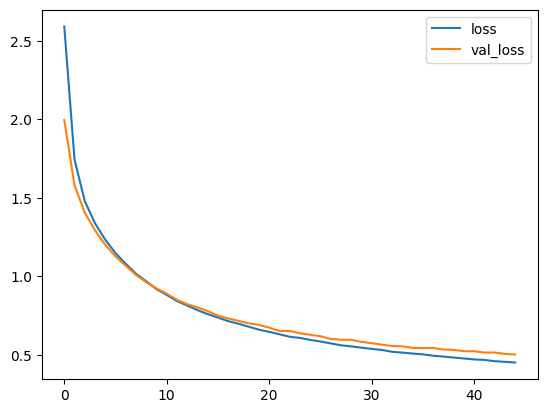

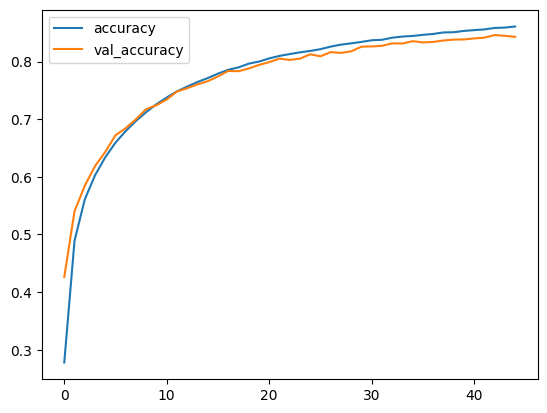

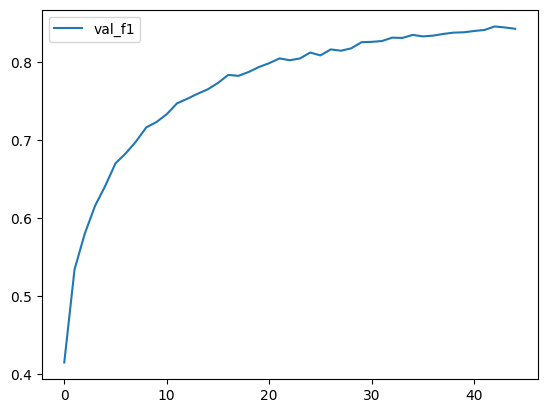

test loss: 0.5067454430221187, test accuracy: 0.8479326923076923, f1: 0.8475233835503702
best test loss: 0.5034204939733844, test accuracy: 0.8459615384615384, test f1: 0.8456668557920257


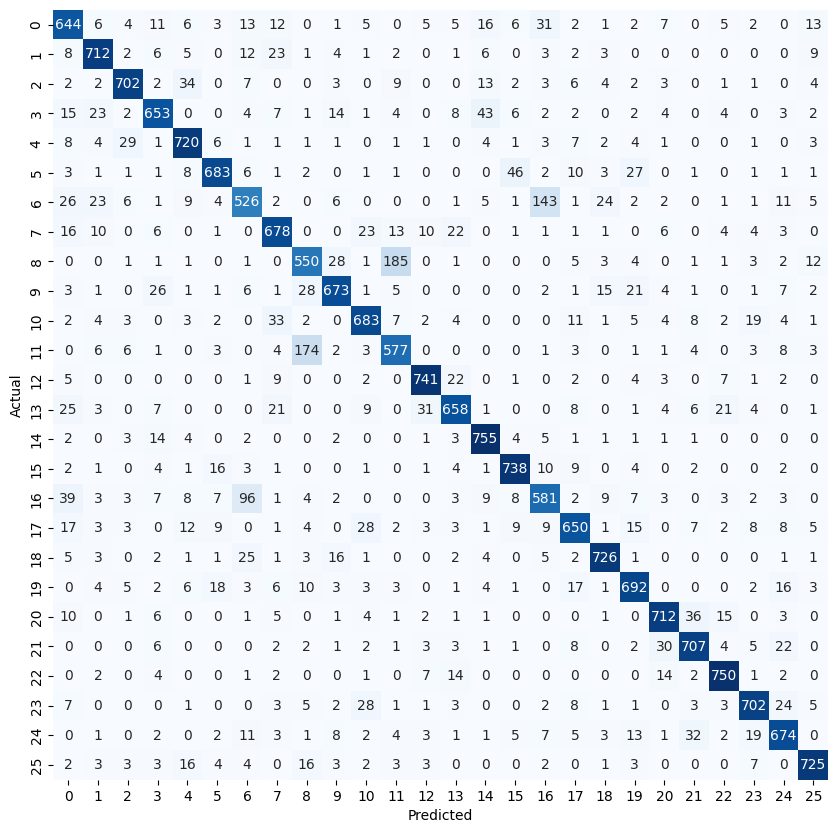

learning rate: 0.0025


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/45, loss: 2.9765, accuracy: 0.1632, val_loss: 2.6314, val_accuracy: 0.2723, val_f1: 0.2527


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/45, loss: 2.3091, accuracy: 0.3538, val_loss: 2.0728, val_accuracy: 0.4084, val_f1: 0.3972


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/45, loss: 1.9068, accuracy: 0.4458, val_loss: 1.7936, val_accuracy: 0.4721, val_f1: 0.4639


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/45, loss: 1.6931, accuracy: 0.5003, val_loss: 1.6307, val_accuracy: 0.5192, val_f1: 0.5135


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/45, loss: 1.5612, accuracy: 0.5372, val_loss: 1.5266, val_accuracy: 0.5480, val_f1: 0.5430


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/45, loss: 1.4655, accuracy: 0.5660, val_loss: 1.4382, val_accuracy: 0.5785, val_f1: 0.5748


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/45, loss: 1.3915, accuracy: 0.5899, val_loss: 1.3757, val_accuracy: 0.5966, val_f1: 0.5935


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/45, loss: 1.3286, accuracy: 0.6067, val_loss: 1.3237, val_accuracy: 0.6097, val_f1: 0.6071


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/45, loss: 1.2782, accuracy: 0.6214, val_loss: 1.2673, val_accuracy: 0.6255, val_f1: 0.6232


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/45, loss: 1.2248, accuracy: 0.6366, val_loss: 1.2180, val_accuracy: 0.6444, val_f1: 0.6419


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/45, loss: 1.1796, accuracy: 0.6503, val_loss: 1.1826, val_accuracy: 0.6512, val_f1: 0.6491


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/45, loss: 1.1434, accuracy: 0.6614, val_loss: 1.1442, val_accuracy: 0.6654, val_f1: 0.6637


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/45, loss: 1.1088, accuracy: 0.6705, val_loss: 1.1062, val_accuracy: 0.6733, val_f1: 0.6717


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/45, loss: 1.0720, accuracy: 0.6812, val_loss: 1.0840, val_accuracy: 0.6822, val_f1: 0.6802


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/45, loss: 1.0456, accuracy: 0.6916, val_loss: 1.0481, val_accuracy: 0.6897, val_f1: 0.6883


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/45, loss: 1.0126, accuracy: 0.6987, val_loss: 1.0172, val_accuracy: 0.7012, val_f1: 0.6996


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/45, loss: 0.9865, accuracy: 0.7075, val_loss: 0.9936, val_accuracy: 0.7055, val_f1: 0.7042


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/45, loss: 0.9634, accuracy: 0.7145, val_loss: 0.9760, val_accuracy: 0.7122, val_f1: 0.7109


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/45, loss: 0.9380, accuracy: 0.7201, val_loss: 0.9545, val_accuracy: 0.7188, val_f1: 0.7175


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/45, loss: 0.9143, accuracy: 0.7277, val_loss: 0.9355, val_accuracy: 0.7259, val_f1: 0.7250


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/45, loss: 0.8948, accuracy: 0.7346, val_loss: 0.9076, val_accuracy: 0.7277, val_f1: 0.7266


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/45, loss: 0.8792, accuracy: 0.7391, val_loss: 0.8967, val_accuracy: 0.7304, val_f1: 0.7291


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/45, loss: 0.8582, accuracy: 0.7433, val_loss: 0.8701, val_accuracy: 0.7418, val_f1: 0.7409


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/45, loss: 0.8436, accuracy: 0.7492, val_loss: 0.8628, val_accuracy: 0.7416, val_f1: 0.7409


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/45, loss: 0.8242, accuracy: 0.7539, val_loss: 0.8463, val_accuracy: 0.7494, val_f1: 0.7486


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/45, loss: 0.8107, accuracy: 0.7580, val_loss: 0.8273, val_accuracy: 0.7552, val_f1: 0.7542


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/45, loss: 0.7996, accuracy: 0.7609, val_loss: 0.8205, val_accuracy: 0.7531, val_f1: 0.7523


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/45, loss: 0.7809, accuracy: 0.7658, val_loss: 0.8031, val_accuracy: 0.7610, val_f1: 0.7601


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/45, loss: 0.7690, accuracy: 0.7695, val_loss: 0.7927, val_accuracy: 0.7615, val_f1: 0.7610


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/45, loss: 0.7574, accuracy: 0.7730, val_loss: 0.7824, val_accuracy: 0.7659, val_f1: 0.7651


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/45, loss: 0.7440, accuracy: 0.7766, val_loss: 0.7718, val_accuracy: 0.7710, val_f1: 0.7701


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/45, loss: 0.7357, accuracy: 0.7800, val_loss: 0.7647, val_accuracy: 0.7719, val_f1: 0.7714


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/45, loss: 0.7238, accuracy: 0.7830, val_loss: 0.7461, val_accuracy: 0.7785, val_f1: 0.7777


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/45, loss: 0.7141, accuracy: 0.7850, val_loss: 0.7376, val_accuracy: 0.7793, val_f1: 0.7786


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/45, loss: 0.7033, accuracy: 0.7888, val_loss: 0.7282, val_accuracy: 0.7830, val_f1: 0.7823


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/45, loss: 0.6941, accuracy: 0.7910, val_loss: 0.7219, val_accuracy: 0.7838, val_f1: 0.7833


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/45, loss: 0.6846, accuracy: 0.7940, val_loss: 0.7190, val_accuracy: 0.7847, val_f1: 0.7840


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/45, loss: 0.6780, accuracy: 0.7966, val_loss: 0.6992, val_accuracy: 0.7916, val_f1: 0.7909


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/45, loss: 0.6712, accuracy: 0.7972, val_loss: 0.6938, val_accuracy: 0.7913, val_f1: 0.7910


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/45, loss: 0.6587, accuracy: 0.8013, val_loss: 0.6906, val_accuracy: 0.7923, val_f1: 0.7919


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/45, loss: 0.6545, accuracy: 0.8040, val_loss: 0.6861, val_accuracy: 0.7940, val_f1: 0.7935


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/45, loss: 0.6472, accuracy: 0.8041, val_loss: 0.6751, val_accuracy: 0.7981, val_f1: 0.7976


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/45, loss: 0.6394, accuracy: 0.8068, val_loss: 0.6591, val_accuracy: 0.8026, val_f1: 0.8023


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/45, loss: 0.6321, accuracy: 0.8092, val_loss: 0.6633, val_accuracy: 0.8000, val_f1: 0.7996


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/45, loss: 0.6258, accuracy: 0.8102, val_loss: 0.6508, val_accuracy: 0.8038, val_f1: 0.8033


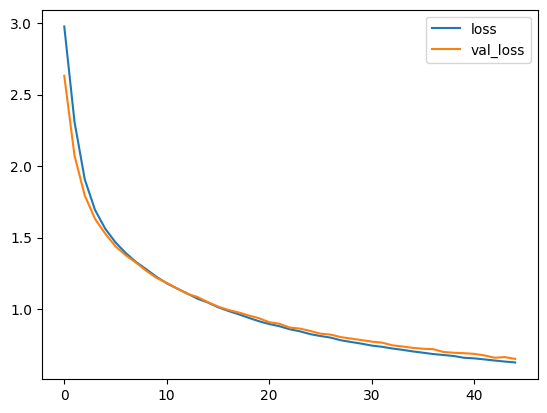

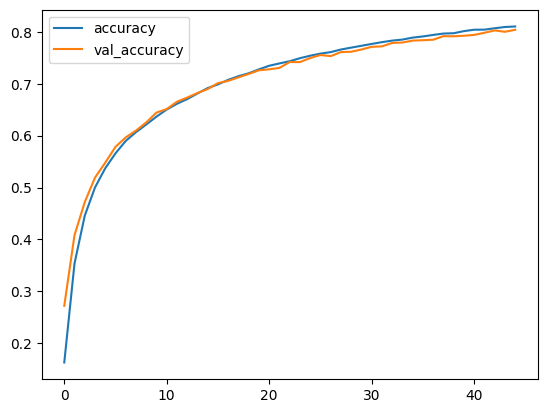

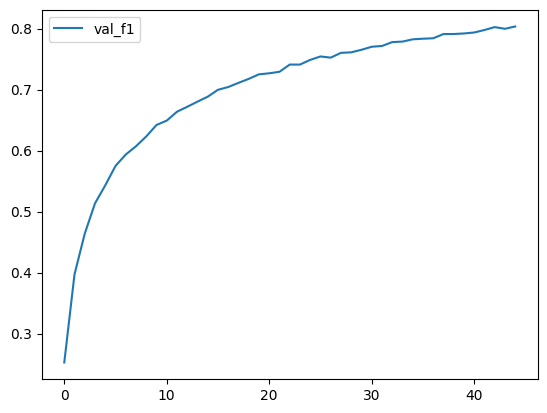

test loss: 0.6443443626645652, test accuracy: 0.808076923076923, f1: 0.807551108686429
best test loss: 0.6500740906234854, test accuracy: 0.8055769230769231, test f1: 0.8050115982809258


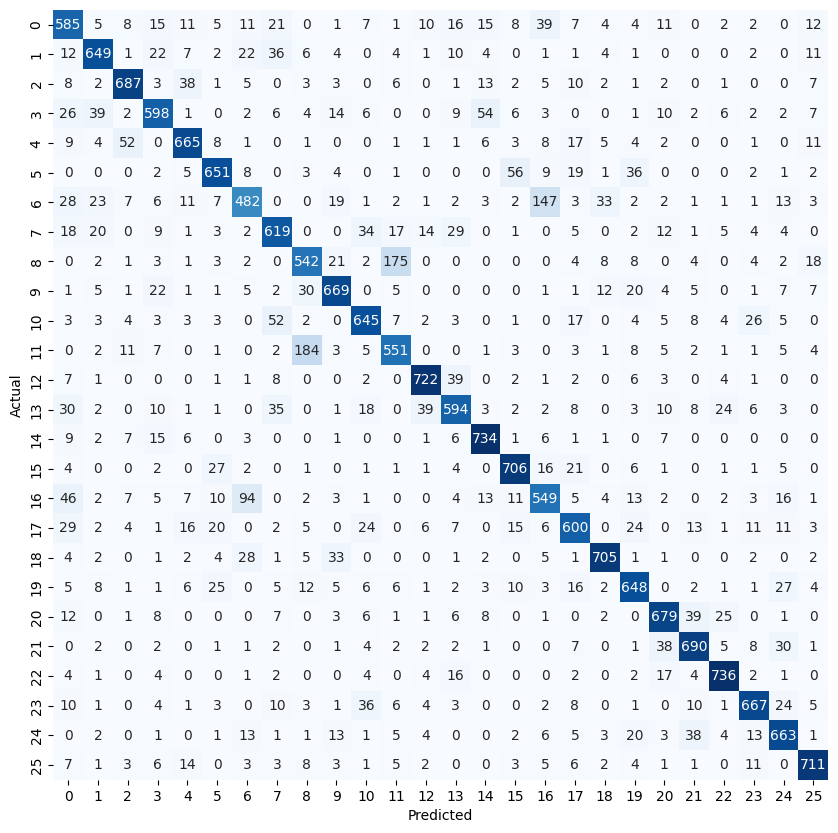

learning rate: 0.001


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/45, loss: 3.1752, accuracy: 0.0955, val_loss: 3.0681, val_accuracy: 0.1548, val_f1: 0.1310


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/45, loss: 2.9222, accuracy: 0.2129, val_loss: 2.7680, val_accuracy: 0.2672, val_f1: 0.2333


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/45, loss: 2.6030, accuracy: 0.3027, val_loss: 2.4516, val_accuracy: 0.3323, val_f1: 0.3087


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/45, loss: 2.3116, accuracy: 0.3628, val_loss: 2.1968, val_accuracy: 0.3882, val_f1: 0.3711


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/45, loss: 2.0960, accuracy: 0.4054, val_loss: 2.0187, val_accuracy: 0.4248, val_f1: 0.4123


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/45, loss: 1.9465, accuracy: 0.4374, val_loss: 1.8895, val_accuracy: 0.4515, val_f1: 0.4425


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/45, loss: 1.8332, accuracy: 0.4676, val_loss: 1.8059, val_accuracy: 0.4668, val_f1: 0.4576


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/45, loss: 1.7468, accuracy: 0.4875, val_loss: 1.7238, val_accuracy: 0.4942, val_f1: 0.4867


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/45, loss: 1.6823, accuracy: 0.5032, val_loss: 1.6643, val_accuracy: 0.5090, val_f1: 0.5017


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/45, loss: 1.6257, accuracy: 0.5210, val_loss: 1.6144, val_accuracy: 0.5238, val_f1: 0.5179


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/45, loss: 1.5766, accuracy: 0.5342, val_loss: 1.5590, val_accuracy: 0.5409, val_f1: 0.5357


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/45, loss: 1.5307, accuracy: 0.5478, val_loss: 1.5216, val_accuracy: 0.5492, val_f1: 0.5440


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/45, loss: 1.4937, accuracy: 0.5585, val_loss: 1.4915, val_accuracy: 0.5613, val_f1: 0.5564


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/45, loss: 1.4628, accuracy: 0.5669, val_loss: 1.4567, val_accuracy: 0.5693, val_f1: 0.5653


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/45, loss: 1.4272, accuracy: 0.5769, val_loss: 1.4244, val_accuracy: 0.5778, val_f1: 0.5733


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/45, loss: 1.3947, accuracy: 0.5875, val_loss: 1.3996, val_accuracy: 0.5860, val_f1: 0.5812


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/45, loss: 1.3661, accuracy: 0.5958, val_loss: 1.3697, val_accuracy: 0.5972, val_f1: 0.5930


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/45, loss: 1.3422, accuracy: 0.6007, val_loss: 1.3470, val_accuracy: 0.6004, val_f1: 0.5966


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/45, loss: 1.3202, accuracy: 0.6084, val_loss: 1.3298, val_accuracy: 0.6071, val_f1: 0.6037


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/45, loss: 1.2948, accuracy: 0.6159, val_loss: 1.3038, val_accuracy: 0.6161, val_f1: 0.6128


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/45, loss: 1.2770, accuracy: 0.6216, val_loss: 1.2794, val_accuracy: 0.6257, val_f1: 0.6223


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/45, loss: 1.2557, accuracy: 0.6291, val_loss: 1.2553, val_accuracy: 0.6313, val_f1: 0.6279


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/45, loss: 1.2360, accuracy: 0.6354, val_loss: 1.2414, val_accuracy: 0.6335, val_f1: 0.6304


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/45, loss: 1.2114, accuracy: 0.6419, val_loss: 1.2264, val_accuracy: 0.6428, val_f1: 0.6396


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/45, loss: 1.2010, accuracy: 0.6449, val_loss: 1.2056, val_accuracy: 0.6470, val_f1: 0.6442


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/45, loss: 1.1796, accuracy: 0.6497, val_loss: 1.1916, val_accuracy: 0.6452, val_f1: 0.6418


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/45, loss: 1.1643, accuracy: 0.6558, val_loss: 1.1691, val_accuracy: 0.6542, val_f1: 0.6511


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/45, loss: 1.1454, accuracy: 0.6620, val_loss: 1.1563, val_accuracy: 0.6618, val_f1: 0.6590


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/45, loss: 1.1333, accuracy: 0.6639, val_loss: 1.1424, val_accuracy: 0.6618, val_f1: 0.6595


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/45, loss: 1.1155, accuracy: 0.6691, val_loss: 1.1237, val_accuracy: 0.6678, val_f1: 0.6655


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/45, loss: 1.1029, accuracy: 0.6722, val_loss: 1.1140, val_accuracy: 0.6675, val_f1: 0.6649


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/45, loss: 1.0908, accuracy: 0.6751, val_loss: 1.0959, val_accuracy: 0.6756, val_f1: 0.6736


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/45, loss: 1.0802, accuracy: 0.6795, val_loss: 1.0969, val_accuracy: 0.6791, val_f1: 0.6772


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/45, loss: 1.0655, accuracy: 0.6840, val_loss: 1.0774, val_accuracy: 0.6813, val_f1: 0.6793


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/45, loss: 1.0515, accuracy: 0.6882, val_loss: 1.0660, val_accuracy: 0.6823, val_f1: 0.6799


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/45, loss: 1.0375, accuracy: 0.6904, val_loss: 1.0507, val_accuracy: 0.6904, val_f1: 0.6884


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/45, loss: 1.0273, accuracy: 0.6945, val_loss: 1.0446, val_accuracy: 0.6920, val_f1: 0.6903


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/45, loss: 1.0176, accuracy: 0.6981, val_loss: 1.0287, val_accuracy: 0.6948, val_f1: 0.6922


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/45, loss: 1.0055, accuracy: 0.6988, val_loss: 1.0185, val_accuracy: 0.6997, val_f1: 0.6974


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/45, loss: 0.9949, accuracy: 0.7042, val_loss: 1.0038, val_accuracy: 0.7067, val_f1: 0.7049


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/45, loss: 0.9838, accuracy: 0.7066, val_loss: 1.0005, val_accuracy: 0.7050, val_f1: 0.7032


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/45, loss: 0.9750, accuracy: 0.7082, val_loss: 0.9945, val_accuracy: 0.7046, val_f1: 0.7030


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/45, loss: 0.9612, accuracy: 0.7132, val_loss: 0.9881, val_accuracy: 0.7034, val_f1: 0.7013


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/45, loss: 0.9484, accuracy: 0.7168, val_loss: 0.9685, val_accuracy: 0.7096, val_f1: 0.7080


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/45, loss: 0.9449, accuracy: 0.7200, val_loss: 0.9635, val_accuracy: 0.7152, val_f1: 0.7138


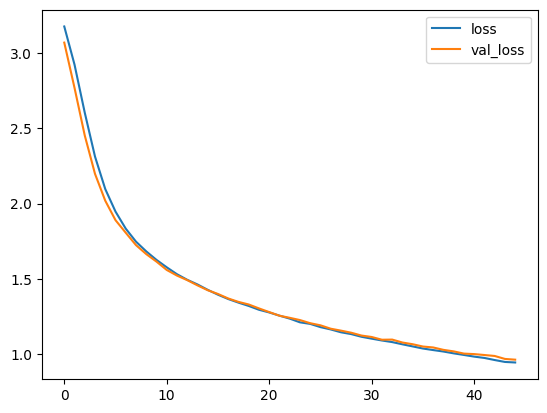

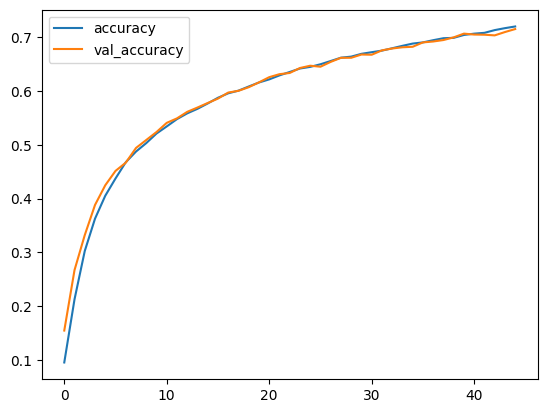

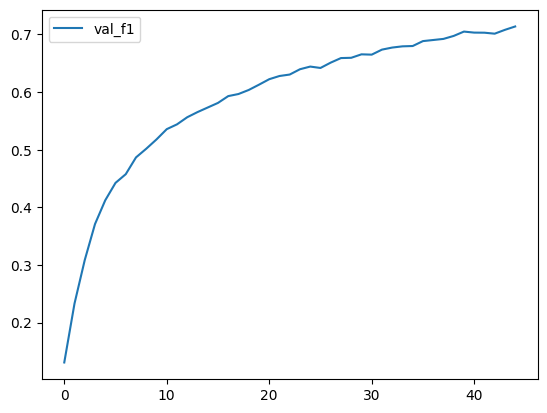

test loss: 0.946136265504629, test accuracy: 0.7179326923076923, f1: 0.7165396244838309
best test loss: 0.944601679751953, test accuracy: 0.71875, test f1: 0.7175449477300737


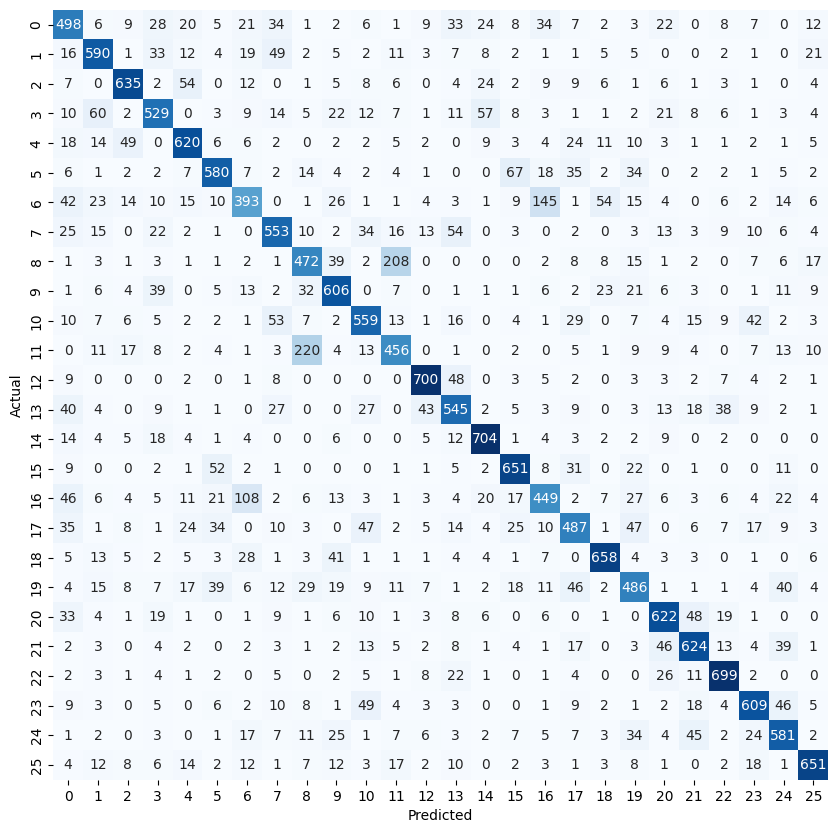

learning rate: 0.00075


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/45, loss: 3.1952, accuracy: 0.0882, val_loss: 3.1102, val_accuracy: 0.1438, val_f1: 0.1147


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/45, loss: 3.0058, accuracy: 0.1890, val_loss: 2.9010, val_accuracy: 0.2276, val_f1: 0.1838


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/45, loss: 2.7794, accuracy: 0.2558, val_loss: 2.6721, val_accuracy: 0.2802, val_f1: 0.2412


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/45, loss: 2.5499, accuracy: 0.3074, val_loss: 2.4536, val_accuracy: 0.3267, val_f1: 0.2988


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/45, loss: 2.3451, accuracy: 0.3488, val_loss: 2.2747, val_accuracy: 0.3635, val_f1: 0.3408


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/45, loss: 2.1763, accuracy: 0.3856, val_loss: 2.1217, val_accuracy: 0.3974, val_f1: 0.3798


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/45, loss: 2.0511, accuracy: 0.4132, val_loss: 2.0089, val_accuracy: 0.4203, val_f1: 0.4049


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/45, loss: 1.9447, accuracy: 0.4364, val_loss: 1.9145, val_accuracy: 0.4437, val_f1: 0.4311


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/45, loss: 1.8641, accuracy: 0.4581, val_loss: 1.8336, val_accuracy: 0.4689, val_f1: 0.4590


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/45, loss: 1.7975, accuracy: 0.4754, val_loss: 1.7719, val_accuracy: 0.4821, val_f1: 0.4725


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/45, loss: 1.7392, accuracy: 0.4901, val_loss: 1.7234, val_accuracy: 0.4968, val_f1: 0.4889


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/45, loss: 1.6946, accuracy: 0.5027, val_loss: 1.6797, val_accuracy: 0.5077, val_f1: 0.5011


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/45, loss: 1.6460, accuracy: 0.5173, val_loss: 1.6410, val_accuracy: 0.5174, val_f1: 0.5100


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/45, loss: 1.6121, accuracy: 0.5241, val_loss: 1.6055, val_accuracy: 0.5263, val_f1: 0.5201


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/45, loss: 1.5760, accuracy: 0.5353, val_loss: 1.5765, val_accuracy: 0.5354, val_f1: 0.5289


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/45, loss: 1.5457, accuracy: 0.5431, val_loss: 1.5413, val_accuracy: 0.5502, val_f1: 0.5439


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/45, loss: 1.5157, accuracy: 0.5528, val_loss: 1.5202, val_accuracy: 0.5560, val_f1: 0.5507


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/45, loss: 1.4930, accuracy: 0.5595, val_loss: 1.5015, val_accuracy: 0.5565, val_f1: 0.5509


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/45, loss: 1.4640, accuracy: 0.5662, val_loss: 1.4685, val_accuracy: 0.5682, val_f1: 0.5631


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/45, loss: 1.4440, accuracy: 0.5741, val_loss: 1.4467, val_accuracy: 0.5732, val_f1: 0.5690


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/45, loss: 1.4200, accuracy: 0.5795, val_loss: 1.4255, val_accuracy: 0.5832, val_f1: 0.5784


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/45, loss: 1.3982, accuracy: 0.5874, val_loss: 1.4100, val_accuracy: 0.5818, val_f1: 0.5771


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/45, loss: 1.3804, accuracy: 0.5923, val_loss: 1.3818, val_accuracy: 0.5967, val_f1: 0.5923


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/45, loss: 1.3641, accuracy: 0.5947, val_loss: 1.3707, val_accuracy: 0.5987, val_f1: 0.5945


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/45, loss: 1.3428, accuracy: 0.6023, val_loss: 1.3456, val_accuracy: 0.6053, val_f1: 0.6011


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/45, loss: 1.3274, accuracy: 0.6080, val_loss: 1.3431, val_accuracy: 0.6024, val_f1: 0.5984


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/45, loss: 1.3112, accuracy: 0.6104, val_loss: 1.3194, val_accuracy: 0.6099, val_f1: 0.6063


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/45, loss: 1.2966, accuracy: 0.6160, val_loss: 1.3026, val_accuracy: 0.6151, val_f1: 0.6115


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/45, loss: 1.2755, accuracy: 0.6234, val_loss: 1.2845, val_accuracy: 0.6231, val_f1: 0.6196


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/45, loss: 1.2654, accuracy: 0.6250, val_loss: 1.2686, val_accuracy: 0.6249, val_f1: 0.6211


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/45, loss: 1.2485, accuracy: 0.6319, val_loss: 1.2592, val_accuracy: 0.6275, val_f1: 0.6247


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/45, loss: 1.2372, accuracy: 0.6340, val_loss: 1.2497, val_accuracy: 0.6333, val_f1: 0.6304


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/45, loss: 1.2209, accuracy: 0.6384, val_loss: 1.2384, val_accuracy: 0.6353, val_f1: 0.6324


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/45, loss: 1.2086, accuracy: 0.6422, val_loss: 1.2306, val_accuracy: 0.6349, val_f1: 0.6320


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/45, loss: 1.1971, accuracy: 0.6433, val_loss: 1.2059, val_accuracy: 0.6456, val_f1: 0.6426


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/45, loss: 1.1829, accuracy: 0.6496, val_loss: 1.1977, val_accuracy: 0.6451, val_f1: 0.6420


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/45, loss: 1.1727, accuracy: 0.6521, val_loss: 1.1802, val_accuracy: 0.6504, val_f1: 0.6477


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/45, loss: 1.1609, accuracy: 0.6553, val_loss: 1.1771, val_accuracy: 0.6512, val_f1: 0.6486


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/45, loss: 1.1466, accuracy: 0.6612, val_loss: 1.1573, val_accuracy: 0.6554, val_f1: 0.6528


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/45, loss: 1.1340, accuracy: 0.6643, val_loss: 1.1547, val_accuracy: 0.6597, val_f1: 0.6573


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/45, loss: 1.1273, accuracy: 0.6662, val_loss: 1.1449, val_accuracy: 0.6606, val_f1: 0.6579


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/45, loss: 1.1172, accuracy: 0.6683, val_loss: 1.1265, val_accuracy: 0.6658, val_f1: 0.6632


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/45, loss: 1.1031, accuracy: 0.6723, val_loss: 1.1279, val_accuracy: 0.6693, val_f1: 0.6670


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/45, loss: 1.0918, accuracy: 0.6753, val_loss: 1.1097, val_accuracy: 0.6669, val_f1: 0.6644


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/45, loss: 1.0839, accuracy: 0.6775, val_loss: 1.0933, val_accuracy: 0.6777, val_f1: 0.6755


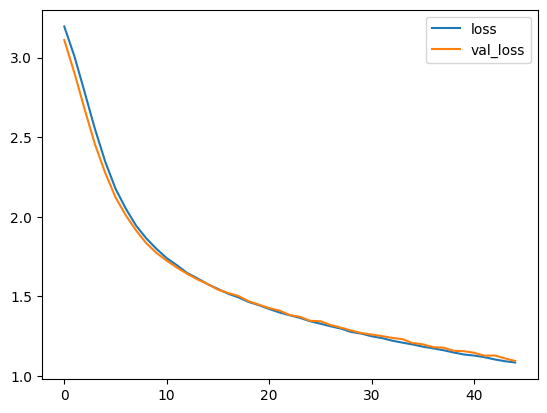

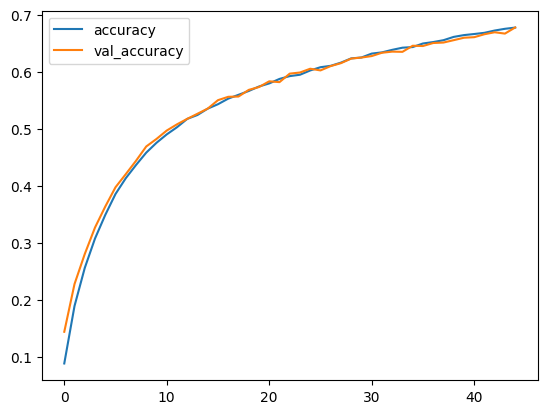

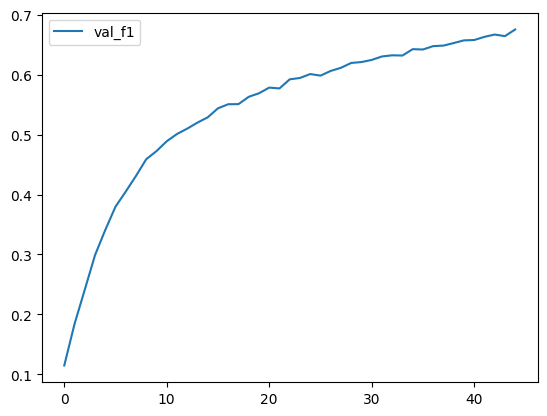

test loss: 1.0942973795204607, test accuracy: 0.671875, f1: 0.6695455187608025
best test loss: 1.0904366363255396, test accuracy: 0.6770673076923077, test f1: 0.6753078778440409


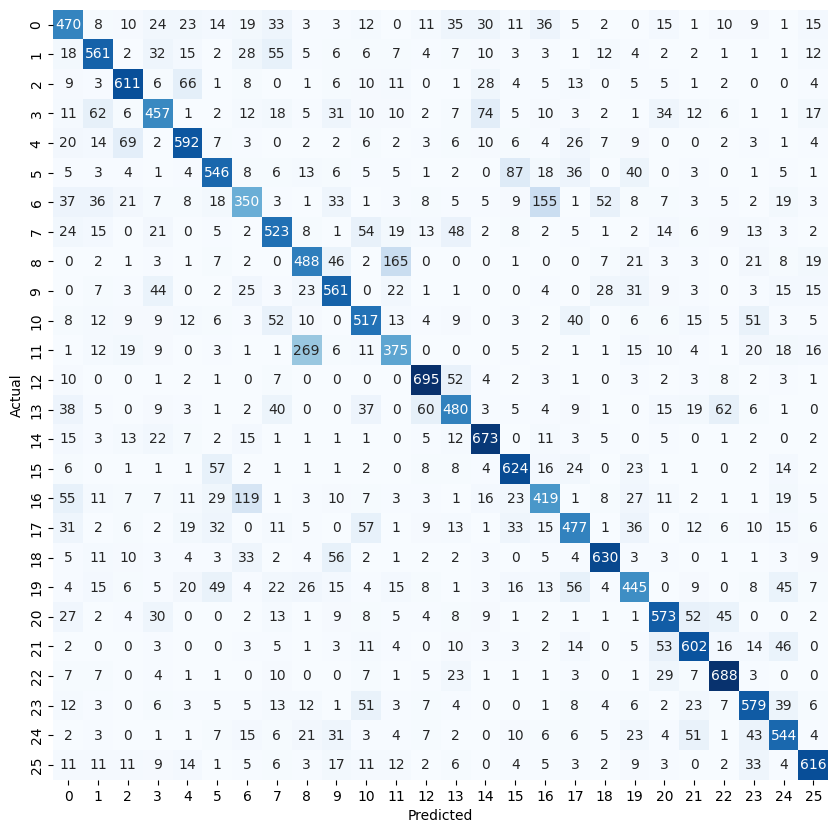

In [32]:
lr = [0.005, 0.0025, 0.001, 0.00075]
for lrate in lr:
    print(f"learning rate: {lrate}")
    print("===============")
    model = FNN(
        loss=CategoricalCrossEntropyLoss(),
        optimizer=SGD(learning_rate=lrate),
        learning_rate=0.0025,
        layers=[
            Flatten(),
            DenseLayer(input_size, 1024, ReLU()),
            DropoutLayer(dropout_rate=0.3),
            DenseLayer(1024, 64, ReLU()),
            DropoutLayer(dropout_rate=0.3),
            DenseLayer(64, output_size, Softmax()),
        ]
    )

    # take only part after decimal point
    lrate_str = str(lrate).split(".")[1]

    # train
    model.fit(
        X=train_ds,
        y=train_labels,
        X_val=val_ds,
        y_val=val_labels,
        epochs=45,
        batch_size=64,
        best_name=f"best1_{lrate_str}.pkl"
    )

    # plot
    model.plot()

    # test model
    X_test = test_ds.data
    y_test = test_ds.targets
    test_loss, test_accuracy, f1 = model.evaluate(X_test, y_test)

    print(f"test loss: {test_loss}, test accuracy: {test_accuracy}, f1: {f1}")


    # test of best model
    test_loss, test_accuracy, f1 = model.best_model_evaluate(X_test, y_test)

    print(f"best test loss: {test_loss}, test accuracy: {test_accuracy}, test f1: {f1}")

    # plot confusion matrix
    model.plot_confusion_matrix(X_test, y_test)

    # save model
    model.save(f"last1_{lrate_str}.pkl")